In [445]:
# filter all the warnings
import warnings
warnings.filterwarnings("ignore")

# data manipulation tools
import pandas as pd
import pandas
import numpy as np

# modeling tools
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from optuna import Trial
from sklearn.metrics import f1_score
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
# from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from autogluon.tabular import TabularDataset, TabularPredictor


# plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyo
import plotly.express as px
pyo.init_notebook_mode()

# model metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

# hyperparameter tuning
import optuna

# model interpretation
import shap
shap.initjs()

# miscellaneous
from pprint import pprint
from joblib import dump
from tqdm import tqdm
from typing import Union, Callable, Tuple, List
import os


In [446]:
data = pd.read_csv('encoded_dataset.csv')
data

Unnamed: 0   Age  Clarity  Color  Transparency  Spec Gravity  pH Level  \
0             0  23.0        1      4             0         1.005       5.0   
1             1  44.0        0      4             2         1.020       6.0   
2             2  22.0        0      5             1         1.025       6.0   
3             3  16.0        0      5             1         1.020       5.0   
4             4  18.0        0      3             1         1.005       6.5   
..          ...   ...      ...    ...           ...           ...       ...   
406         407  24.0        0      3             1         1.010       6.0   
407         408  46.0        0      3             1         1.015       6.0   
408         409  33.0        0      3             1         1.025       6.0   
409         410  25.0        0      4             1         1.010       6.0   
410         411  65.0        0      5             2         1.030       6.0   

     Leukocytes  Nitrite  Protein  ...  RBC  WBC  Mucus Threads  \
0             0        0        0  ...    0    0              1   
1             0        0        0  ...    3    0              3   
2             0        0        2  ...    0    0              1   
3             0        0        0  ...    0    0              2   
4             0        0        0  ...    0    0              1   
..          ...      ...      ...  ...  ...  ...            ...   
406           0        0        0  ...    0    0              1   
407           0        0        0  ...    0    0              1   
408           0        0        0  ...    0    0              2   
409           0        0        0  ...    0    0              1   
410           3        0        0  ...    4    3              3   

     Amorphous Urate/Phosphate  DIAGNOSIS  Marital Status_MARRIED  \
0                           -1          0                   False   
1                            0          0                    True   
2                            1          0                   False   
3                            0          0                   False   
4                            0          0                   False   
..                         ...        ...                     ...   
406                          0          0                   False   
407                          0          0                    True   
408                          0          0                    True   
409                          0          0                    True   
410                          3          1                    True   

     Marital Status_SINGLE  Marital Status_WIDOW  FEMALE  FILIPINO  
0                     True                 False    True      True  
1                    False                 False    True      True  
2                     True                 False    True      True  
3                     True                 False    True      True  
4                     True                 False   False      True  
..                     ...                   ...     ...       ...  
406                   True                 False    True      True  
407                  False                 False    True      True  
408                  False                 False    True      True  
409                  False                 False    True      True  
410                  False                 False   False      True  

[411 rows x 27 columns]

In [447]:
X = data.drop(columns=['DIAGNOSIS', 'Unnamed: 0'])  
y = data['DIAGNOSIS']

In [448]:
X.columns

Index(['Age', 'Clarity', 'Color', 'Transparency', 'Spec Gravity', 'pH Level',
       'Leukocytes', 'Nitrite', 'Protein', 'Glucose', 'Ketones',
       'Urobilinogen', 'Bilirubin', 'Blood', 'Bacteria', 'Epithelial Cells',
       'RBC', 'WBC', 'Mucus Threads', 'Amorphous Urate/Phosphate',
       'Marital Status_MARRIED', 'Marital Status_SINGLE',
       'Marital Status_WIDOW', 'FEMALE', 'FILIPINO'],
      dtype='object')

In [449]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [450]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)


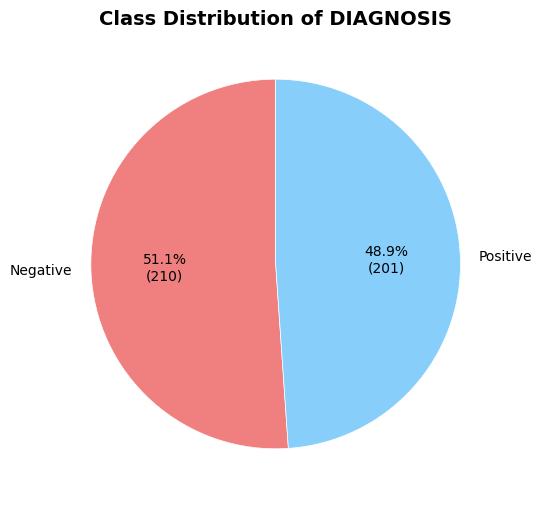

In [451]:
class_counts = y.value_counts()
labels = ['Negative', 'Positive']

def autopct_format(values):
    def inner_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count:d})'
    return inner_autopct

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=labels, autopct=autopct_format(class_counts), startangle=90, 
        colors=['lightcoral', 'lightskyblue'], wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'})

plt.title('Class Distribution of DIAGNOSIS', fontsize=14, fontweight='bold')

plt.show()

In [452]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, 
                                                                    y_train, 
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                   stratify = y_train)

In [453]:
def show_study_summary(study: optuna.study.Study) -> None:
    print("\033[1mBest Hyperparameters")
    pprint(study.best_params)
    print()

    print("\033[1mAccuracy for the Best Hyperparameters")
    print(study.best_value)

    optimization_history_plot = optuna.visualization.plot_optimization_history(study)
    param_importances_plot = optuna.visualization.plot_param_importances(study)


    optimization_history_plot.update_layout({"height": 600})
    param_importances_plot.update_layout({"height": 600})


    optimization_history_plot.show()
    param_importances_plot.show()


## Logistic Regression

In [454]:
def logreg_objective(trial: optuna.study.Study) -> float:
    PARAMS = {
        "tol": trial.suggest_float("tol", 1e-6, 1e-2, log=True),
        "C": trial.suggest_float("C", 0.1, 1),
    }

    LOGREG = LogisticRegression(**PARAMS, max_iter=2000, random_state=42)

    LOGREG.fit(X_train_val, y_train_val)

    THRESHOLD = trial.suggest_float('threshold', 0.1, 1)

    YHAT = [1 if proba[1] > THRESHOLD else 0 for proba in LOGREG.predict_proba(X_test_val)]

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)


LOGREG_STUDY = optuna.create_study(direction="maximize", study_name="logreg_tuning", sampler=SAMPLER)

LOGREG_STUDY.optimize(logreg_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-13 20:24:45,993] A new study created in memory with name: logreg_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-13 20:24:46,113] Trial 0 finished with value: 0.8235294117647058 and parameters: {'tol': 3.3327966966099885e-05, 'C': 0.9600909885273768, 'threshold': 0.9449147524378492}. Best is trial 0 with value: 0.8235294117647058.
[I 2024-11-13 20:24:46,118] Trial 4 finished with value: 0.75 and parameters: {'tol': 0.005620034257355162, 'C': 0.35236835973317415, 'threshold': 0.9240750376906166}. Best is trial 0 with value: 0.8235294117647058.
[I 2024-11-13 20:24:46,130] Trial 3 finished with value: 0.8923076923076924 and parameters: {'tol': 5.417359126379573e-06, 'C': 0.6560287192968706, 'threshold': 0.11761382197011486}. Best is trial 3 with value: 0.8923076923076924.
[I 2024-11-13 20:24:46,133] Trial 1 finished with value: 0.8461538461538461 and parameters: {'tol': 8.912573973239189e-06, 'C': 0.6771311495085712, 'threshold': 0.8866901048703205}. Best is trial 3 with value: 0.8923076923076924.
[I 2024-11-13 20:24:46,142] Trial 2 finished with value: 0.8955223880597015 and parameters: 

In [455]:
show_study_summary(LOGREG_STUDY)

Best Hyperparameters
{'C': 0.18759391363035358,
 'threshold': 0.27423397018907547,
 'tol': 0.00631643395542802}

Accuracy for the Best Hyperparameters
0.9508196721311475


## Support Vector Machine

In [456]:
def SVC_objective(trial: optuna.study.Study) -> float:
    PARAMS = {
        "C": trial.suggest_float("C", 0.1, 10, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }

    SVC_MODEL = SVC(**PARAMS, probability=True, random_state=42)

    SVC_MODEL.fit(X_train_val, y_train_val)

    YHAT = SVC_MODEL.predict(X_test_val)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

SVM_SVC_STUDY = optuna.create_study(direction="maximize", study_name="SVM_tuning", sampler=SAMPLER)

SVM_SVC_STUDY.optimize(SVC_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-13 20:24:50,878] A new study created in memory with name: SVM_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-13 20:24:50,930] Trial 3 finished with value: 0.9310344827586207 and parameters: {'C': 0.4241596084767063, 'kernel': 'linear'}. Best is trial 3 with value: 0.9310344827586207.
[I 2024-11-13 20:24:50,933] Trial 1 finished with value: 0.8 and parameters: {'C': 0.8483933158582858, 'kernel': 'poly'}. Best is trial 3 with value: 0.9310344827586207.
[I 2024-11-13 20:24:50,936] Trial 0 finished with value: 0.6956521739130435 and parameters: {'C': 0.31392489399663676, 'kernel': 'poly'}. Best is trial 3 with value: 0.9310344827586207.
[I 2024-11-13 20:24:50,937] Trial 5 finished with value: 0.9285714285714286 and parameters: {'C': 3.7609205616907113, 'kernel': 'rbf'}. Best is trial 3 with value: 0.9310344827586207.
[I 2024-11-13 20:24:50,938] Trial 2 finished with value: 0.6363636363636364 and parameters: {'C': 0.280681532662762, 'kernel': 'poly'}. Best is trial 3 with value: 0.9310344827586207.
[I 2024-11-13 20:24:50,946] Trial 7 finished with value: 0.8888888888888888 and parameter

In [457]:
show_study_summary(SVM_SVC_STUDY)

Best Hyperparameters
{'C': 9.245129038963741, 'kernel': 'sigmoid'}

Accuracy for the Best Hyperparameters
0.9666666666666667


## XGBoost


In [458]:
def XGB_objective(trial: optuna.study.Study) -> float:

    PARAMS = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }

    XGB_model = xgb.XGBClassifier(**PARAMS, random_state=42)

    XGB_model.fit(X_train_val, y_train_val)

    YHAT = XGB_model.predict(X_test_val)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

XGB_STUDY = optuna.create_study(direction="maximize", study_name="XGB_tuning", sampler=SAMPLER)

XGB_STUDY.optimize(XGB_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-13 20:24:53,833] A new study created in memory with name: XGB_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-13 20:24:54,127] Trial 7 finished with value: 0.9508196721311475 and parameters: {'reg_alpha': 0.514092954045124, 'n_estimators': 250, 'max_depth': 11, 'learning_rate': 0.00047381179777341626, 'subsample': 0.6696242715354072, 'colsample_bytree': 0.9701315008448044}. Best is trial 7 with value: 0.9508196721311475.
[I 2024-11-13 20:24:54,276] Trial 1 finished with value: 0.9830508474576272 and parameters: {'reg_alpha': 0.26499382930678195, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.0009408007331555917, 'subsample': 0.6712135090557374, 'colsample_bytree': 0.8141252437316393}. Best is trial 1 with value: 0.9830508474576272.
[I 2024-11-13 20:24:54,387] Trial 0 finished with value: 0.9655172413793104 and parameters: {'reg_alpha': 0.7543870354702163, 'n_estimators': 550, 'max_depth': 8, 'learning_rate': 0.056804032787605124, 'subsample': 0.8872729691544531, 'colsample_bytree': 0.672398648179612}. Best is trial 1 with value: 0.9830508474576272.
[I 2024-11-13 20:24:54,48

In [459]:
show_study_summary(XGB_STUDY)

Best Hyperparameters
{'colsample_bytree': 0.8141252437316393,
 'learning_rate': 0.0009408007331555917,
 'max_depth': 9,
 'n_estimators': 400,
 'reg_alpha': 0.26499382930678195,
 'subsample': 0.6712135090557374}

Accuracy for the Best Hyperparameters
0.9830508474576272


## LGBM

In [460]:
def lightgbm_objective(trial: optuna.study.Study) -> float:

    PARAMS = {
        "data_sample_strategy": "goss",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int('num_leaves', 10, 200, step=10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 3, 4, 5]),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)
    }
    
    LGMB_MODEL = lgb.LGBMClassifier(**PARAMS, random_state=42)
    
    LGMB_MODEL.fit(X_train_val, y_train_val) 
    
    YHAT = LGMB_MODEL.predict(X_test_val)
    
    F1_SCORE_ = f1_score(y_test_val, YHAT)
    
    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

LGBM_STUDY = optuna.create_study(direction="maximize", study_name="lgbm_tuning", sampler=SAMPLER)

LGBM_STUDY.optimize(lightgbm_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-13 20:25:22,771] A new study created in memory with name: lgbm_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-13 20:25:22,920] Trial 1 finished with value: 0.8405797101449275 and parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.0004386560252845798, 'reg_alpha': 0.48462255695660783, 'subsample': 0.8114741841120077, 'colsample_bytree': 0.5213130238827303, 'min_child_samples': 89}. Best is trial 1 with value: 0.8405797101449275.
[I 2024-11-13 20:25:22,951] Trial 2 finished with value: 0.8955223880597015 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.002018509473954877, 'reg_alpha': 0.8835893339779218, 'subsample': 0.5113831056649736, 'colsample_bytree': 0.9983479126453249, 'min_child_samples': 32}. Best is trial 2 with value: 0.8955223880597015.
[I 2024-11-13 20:25:22,968] Trial 4 finished with value: 0.8955223880597015 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0003075484255673884

In [461]:
show_study_summary(LGBM_STUDY)

Best Hyperparameters
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6816403544224076,
 'learning_rate': 0.005694214225735551,
 'max_depth': -1,
 'min_child_samples': 59,
 'n_estimators': 150,
 'num_leaves': 60,
 'reg_alpha': 0.45995687585307576,
 'subsample': 0.7178008254200614}

Accuracy for the Best Hyperparameters
0.9836065573770492


## TabNet

In [462]:
# def tabnet_objective(trial: optuna.study.Study) -> float:

#     PARAMS = {
#     "n_d": trial.suggest_int('n_d', 8, 64),  
#     "n_a": trial.suggest_int('n_a', 8, 64), 
#     "n_steps": trial.suggest_int('n_steps', 3, 10),  
#     "gamma": trial.suggest_float('gamma', 1.0, 2.0),  
#     "lambda_sparse": trial.suggest_float('lambda_sparse', 1e-5, 1e-3, log=True), 
#     "n_independent": trial.suggest_int('n_independent', 1, 5),  
#     "n_shared": trial.suggest_int('n_shared', 1, 5)  
#     }

#     TAB_MODEL = TabNetClassifier(**PARAMS)

#     TAB_MODEL.fit(X_train_val, y_train_val,
#         max_epochs=100,
#         patience=15,  
#         batch_size=528,
#         virtual_batch_size=64)

#     YHAT = TAB_MODEL.predict(X_test_val)

#     F1_SCORE_ = f1_score(y_test_val, YHAT)

#     return F1_SCORE_

# SEED = 42  
# SAMPLER = optuna.samplers.TPESampler(seed=SEED)

# TABNET_STUDY = optuna.create_study(direction="maximize", study_name="tabnet_tuning", sampler=SAMPLER)

# TABNET_STUDY.optimize(tabnet_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)


In [463]:
# show_study_summary(TABNET_STUDY)

In [464]:
from typing import Union, Tuple
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def test_model(
        models: list,
        params: dict,
        X_train: Union[np.ndarray, pd.DataFrame],
        y_train: Union[np.ndarray, pd.Series],
        X_test: Union[np.ndarray, pd.DataFrame],
        y_test: Union[np.ndarray, pd.Series]
    ) -> Tuple[dict, pd.DataFrame]:

    model_testing_scores = pd.DataFrame()
    models_container = {}

    model_testing_scores["Model"] = []
    model_testing_scores["Accuracy"] = []
    model_testing_scores["Precision"] = []
    model_testing_scores["Recall"] = []
    model_testing_scores["F1-Score"] = []
    model_testing_scores["Specificity"] = []
    model_testing_scores["AUC-ROC"] = []

    for model in tqdm(models):
        MODEL_NAME = model().__class__.__name__
        MODEL_KEY = MODEL_NAME + "_R" if (MODEL_NAME + "_R") in params else MODEL_NAME

        # Check if model is Logistic Regression with a threshold
        if MODEL_KEY == "LogisticRegression_R" or MODEL_KEY == "LogisticRegression":
            test_model = model(tol=params[MODEL_KEY]["tol"],
                               C=params[MODEL_KEY]["C"],
                               max_iter=2000)
            test_model.fit(X_train, y_train)

            # Apply custom threshold
            test_pred = [1 if proba[1] > params[MODEL_KEY]["threshold"] else 0 for proba in
                         test_model.predict_proba(X_test)]

        # Check if model is TabNetClassifier
        elif MODEL_KEY == "TabNetClassifier":
            # Convert to numpy arrays if they are DataFrames for TabNet compatibility
            X_train_input = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
            X_test_input = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

            test_model = model(**params[MODEL_KEY])
            test_model.fit(X_train_input, y_train)  # Use numpy array
            test_pred = test_model.predict(X_test_input)  # Use numpy array

        # For all other models
        else:
            test_model = model(**params[MODEL_KEY])
            test_model.fit(X_train, y_train)
            test_pred = test_model.predict(X_test)

        # Calculate metrics
        TN, FP, _, _ = confusion_matrix(y_test, test_pred).ravel()
        TESTING_SPECIFICITY = TN / (TN + FP)

        # Append results to the DataFrame
        model_testing_scores = model_testing_scores._append({
            "Model": MODEL_KEY,
            "Accuracy": accuracy_score(y_test, test_pred),
            "Precision": precision_score(y_test, test_pred),
            "Recall": recall_score(y_test, test_pred),
            "F1-Score": f1_score(y_test, test_pred),
            "Specificity": TESTING_SPECIFICITY,
            "AUC-ROC": roc_auc_score(y_test, test_pred)
        }, ignore_index=True)

        # Store the trained model in the container
        models_container[MODEL_KEY] = test_model

    return models_container, model_testing_scores


In [465]:
LIST_OF_MODELS = [LogisticRegression, SVC, xgb.XGBClassifier, lgb.LGBMClassifier, TabNetClassifier]

MODELS_PARAMETERS = {"LogisticRegression":{'C': 0.2365747466226469,
                    'threshold': 0.29343601050837254,
                    'tol': 2.28895425023624e-06
                    },
                     
                    "SVC":{'C': 0.4018032075748924, 'kernel': 'linear', 'probability': True},
                     
                    "XGBClassifier":{'learning_rate': 0.013063286229945145,
                                    'max_depth': 11,
                                    'n_estimators': 300,
                                    'reg_alpha': 0.8231888739256502
                                    },
                     
                     "LGBMClassifier": {"data_sample_strategy": "goss",
                                        "verbosity": -1, 
                                        'boosting_type': 'gbdt',
                                        'learning_rate': 0.07123575107452054,
                                        'max_depth': 5,
                                        'n_estimators': 200,
                                        'num_leaves': 100,
                                        'reg_alpha': 0.3771805609488842

                                        },
                    "TabNetClassifier": {'gamma': 1.4803802329168332,
                                        'lambda_sparse': 7.110709471474281e-05,
                                        'n_a': 17,
                                        'n_d': 13,
                                        'n_independent': 3,
                                        'n_shared': 4,
                                        'n_steps': 7
                                        }
                    }


MODEL_CONTAINER, TESTING_SCORES = test_model(LIST_OF_MODELS, MODELS_PARAMETERS, X_train, y_train, X_test, y_test)

100%|██████████| 5/5 [00:00<00:00, 10.81it/s]

epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

In [466]:
def display_confusion_matrices(model_container, X_test, y_test):
    for name, model in model_container.items():
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix for {name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

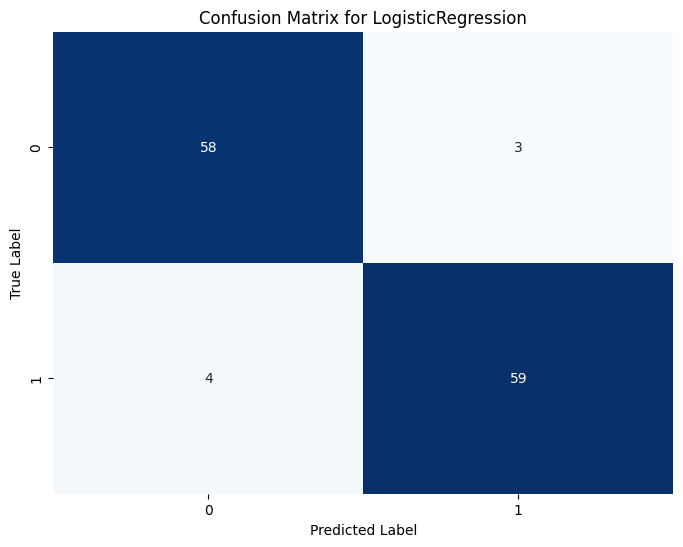

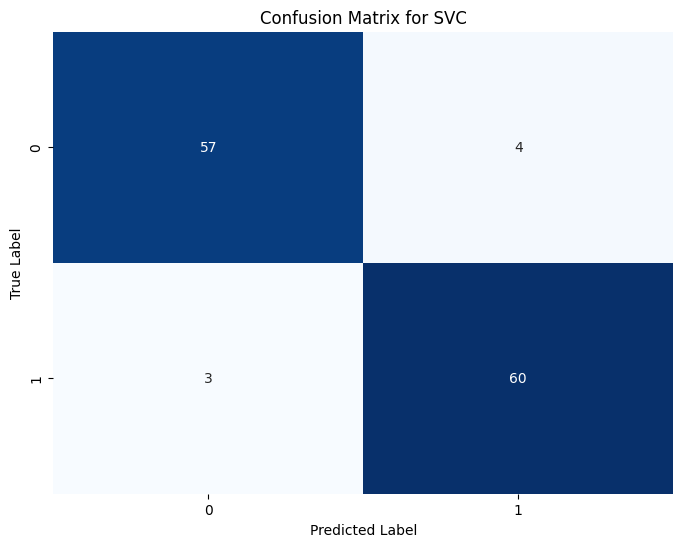

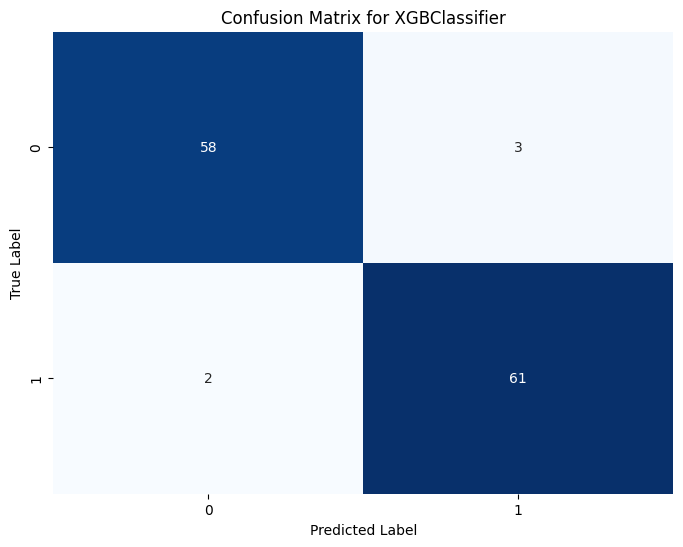

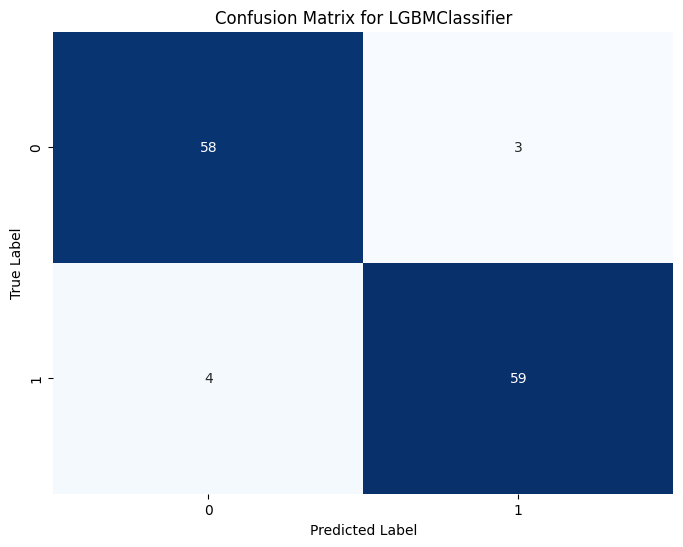

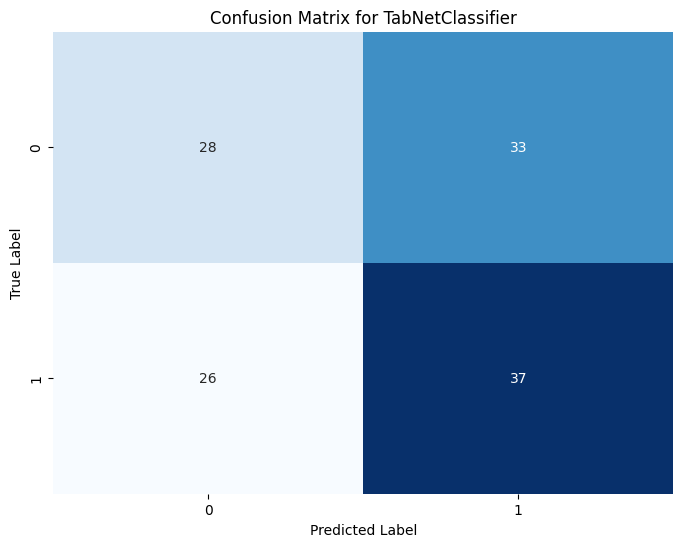

In [467]:
display_confusion_matrices(MODEL_CONTAINER, X_test, y_test)

In [468]:
TESTING_SCORES

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  LogisticRegression  0.943548   0.924242  0.968254  0.945736     0.918033   
1                 SVC  0.943548   0.937500  0.952381  0.944882     0.934426   
2       XGBClassifier  0.959677   0.953125  0.968254  0.960630     0.950820   
3      LGBMClassifier  0.943548   0.951613  0.936508  0.944000     0.950820   
4    TabNetClassifier  0.524194   0.528571  0.587302  0.556391     0.459016   

    AUC-ROC  
0  0.943143  
1  0.943404  
2  0.959537  
3  0.943664  
4  0.523159

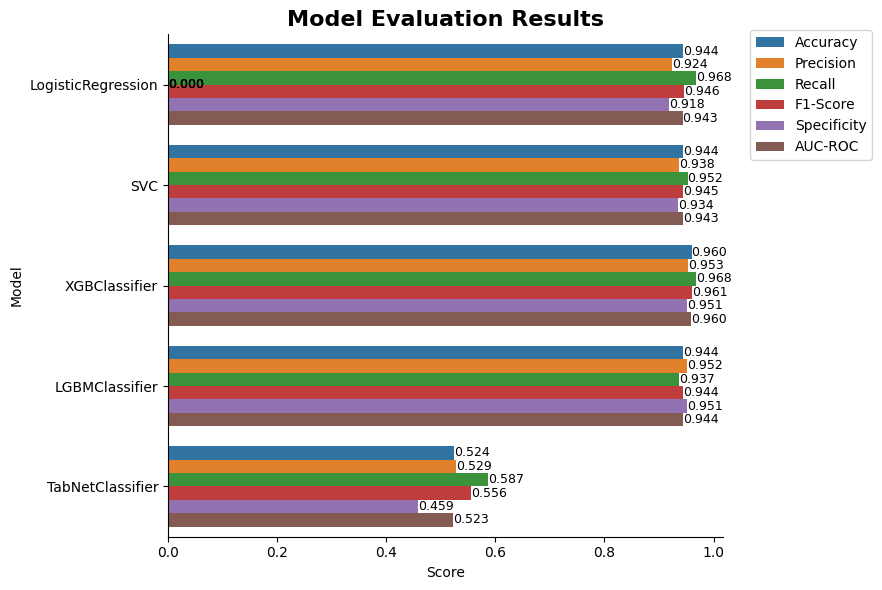

In [469]:
# Prepare data for plotting
plot_df = pd.melt(TESTING_SCORES, id_vars=["Model"])
plot_df.rename({"variable": "Metric", "value": "Score"}, axis=1, inplace=True)

PLOT = sns.catplot(
    x="Score", 
    y="Model", 
    hue="Metric", 
    data=plot_df, 
    kind="bar", 
    orient="h",
    height=6, 
    aspect=1.5, 
    legend_out=False,
    palette="tab10"  
)

# Access the axes of the plot
ax = PLOT.axes[0, 0]

# Annotate the bars with their corresponding scores
for p in ax.patches:
    ax.annotate(f"{p.get_width():.3f}", 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha="left", va="center", fontsize=9)

# Set plot title and legend
plt.title("Model Evaluation Results", fontsize=16, fontweight='bold')
plt.legend(loc=(1.05, 0.75))
plt.tight_layout()

# Display the plot
plt.show()


In [470]:
def plot_feature_importances(model, X_columns, title, top_n=20):

    # Extract and sort feature importances
    results = {column: value for value, column in zip(model.feature_importances_, X_columns)}
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)[:top_n]  # Top N features

    # Separate names and values for the top features
    feature_names, importances = zip(*sorted_results)

    plt.figure(figsize=(14, 8))  
    plt.barh(range(len(importances)), importances, align='center', color="lightblue")
    plt.yticks(range(len(feature_names)), [name[:15] + '...' if len(name) > 15 else name for name in feature_names], fontsize=9)

    # Set titles and labels
    plt.title(f"{title}: Top {top_n} Feature Importance", fontsize=14, fontweight='bold')
    plt.xlabel("Feature importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.ylim(-1, top_n)
    plt.gca().invert_yaxis()  
    plt.show()



In [471]:
TRAINED_XGB = MODEL_CONTAINER["XGBClassifier"]
TRAINED_LGBM = MODEL_CONTAINER["LGBMClassifier"]
TRAINED_SVM = MODEL_CONTAINER["SVC"]
TRAINED_LOGREG = MODEL_CONTAINER["LogisticRegression"]
TRAINED_TABNET = MODEL_CONTAINER["TabNetClassifier"]

## TABNET FEATURE IMPORTANCE

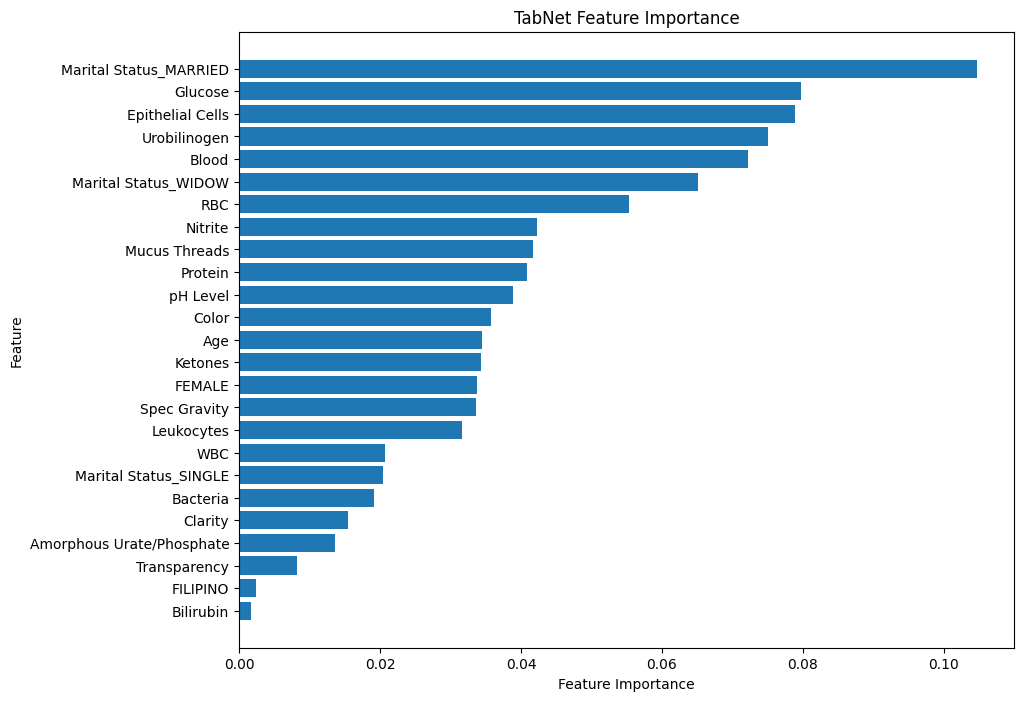

In [472]:
feature_importances = TRAINED_TABNET.feature_importances_ 
feature_names = X.columns 
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("TabNet Feature Importance")
plt.gca().invert_yaxis()
plt.show()

## XGB SHAP

In [473]:
XGB_EXPLAINER = shap.TreeExplainer(TRAINED_XGB, X_test)

XGB_SHAP_VALUES = XGB_EXPLAINER.shap_values(X_test, check_additivity=False)

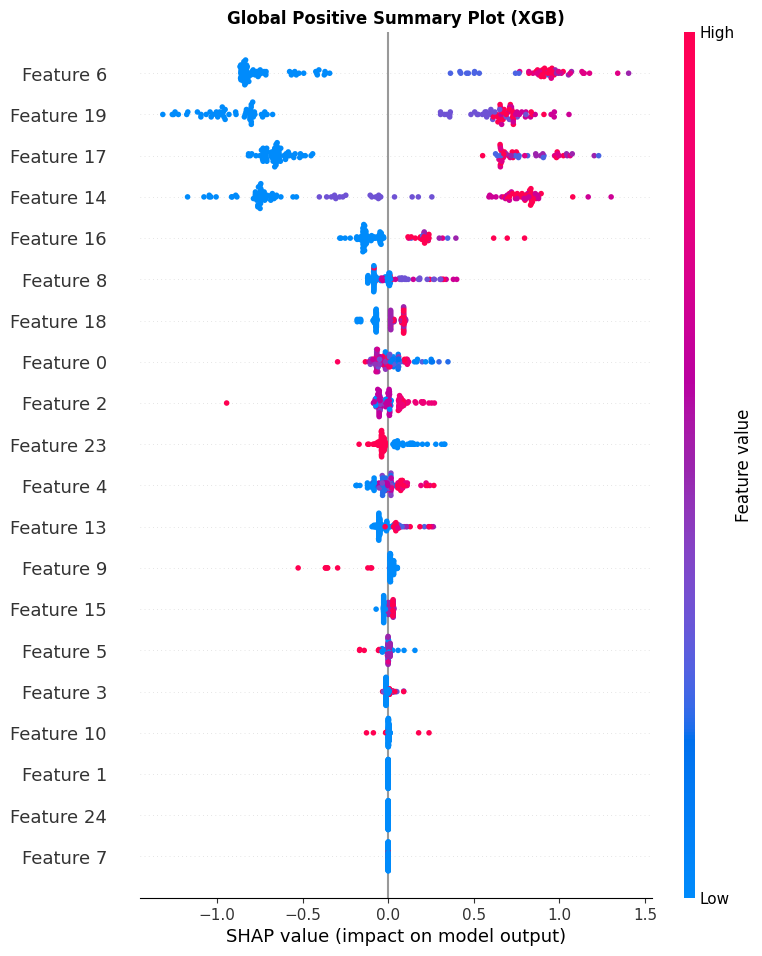

In [474]:
# SHAP Global Positive Summary Plot
shap.summary_plot(XGB_SHAP_VALUES, X_test, show=False)
plt.title("Global Positive Summary Plot (XGB)", fontdict={"fontweight":"bold"})
plt.show()

## LGB SHAP

In [475]:
LGBM_EXPLAINER = shap.TreeExplainer(TRAINED_LGBM, X_test)

LGBM_SHAP_VALUES = LGBM_EXPLAINER.shap_values(X_test, check_additivity=False)

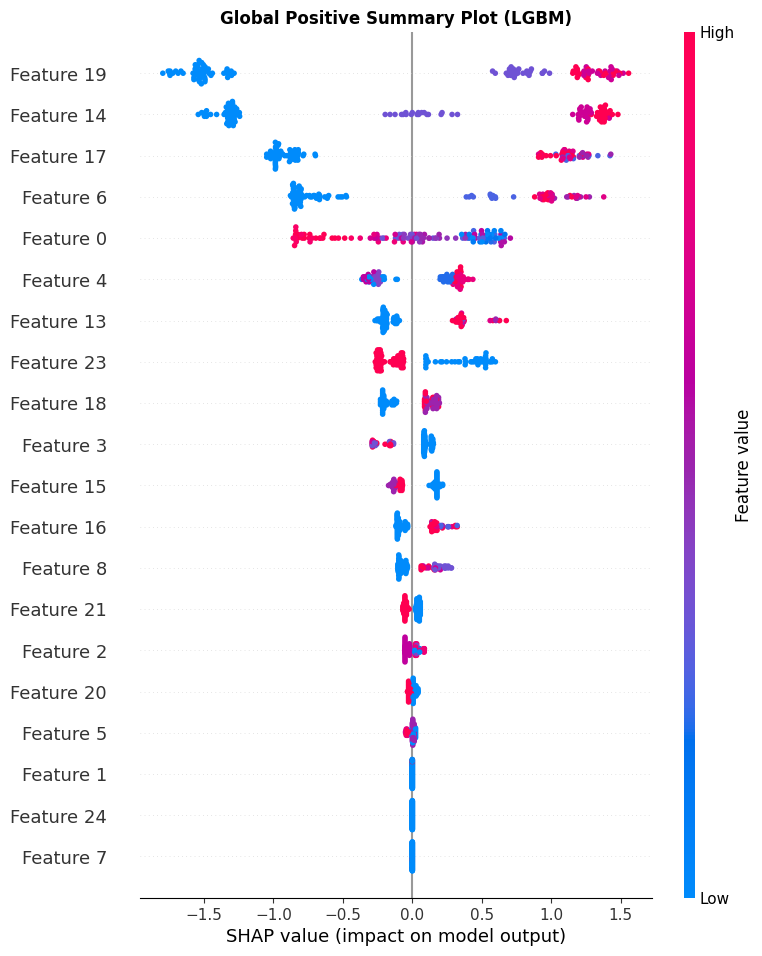

In [476]:
# SHAP Global Positive Summary Plot
shap.summary_plot(LGBM_SHAP_VALUES, X_test, show=False)
plt.title("Global Positive Summary Plot (LGBM)", fontdict={"fontweight":"bold"})
plt.show()

## LOGREG SHAP

In [477]:
LOGREG_EXPLAINER = shap.LinearExplainer(TRAINED_LOGREG, X_test)

LOGREG_SHAP_VALUES = LOGREG_EXPLAINER.shap_values(X_test)

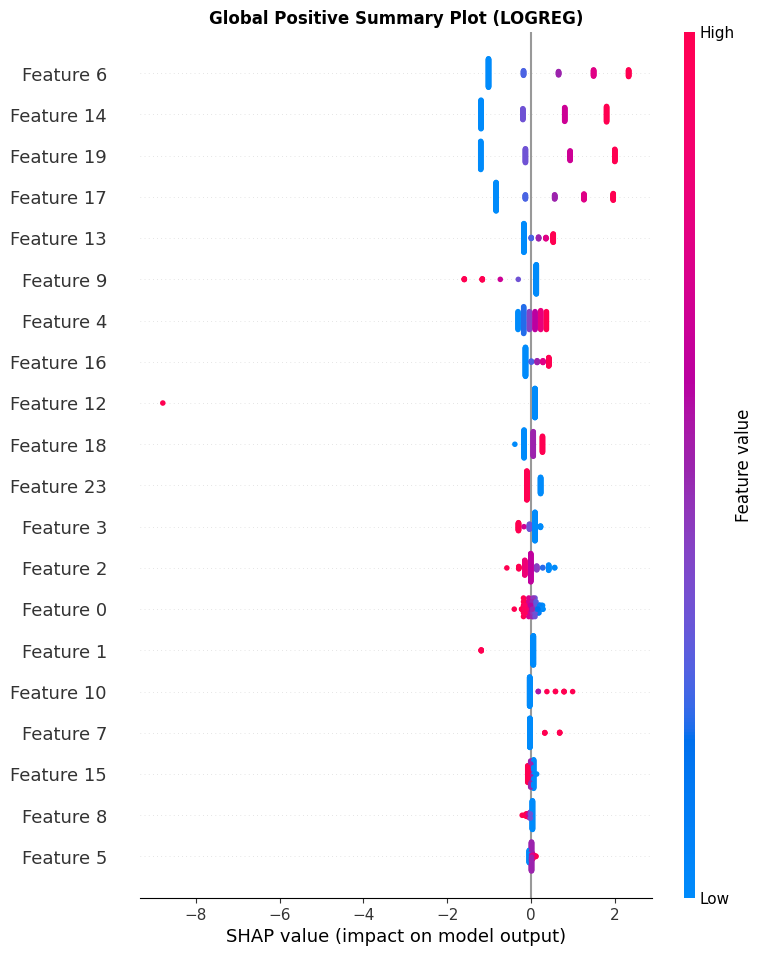

In [478]:
# SHAP Global Positive Summary Plot
shap.summary_plot(LOGREG_SHAP_VALUES, X_test, show=False)
plt.title("Global Positive Summary Plot (LOGREG)", fontdict={"fontweight":"bold"})
plt.show()

## SVM SHAP

In [479]:
SVM_EXPLAINER = shap.LinearExplainer(TRAINED_SVM, X_test)

SVM_SHAP_VALUES = SVM_EXPLAINER.shap_values(X_test)

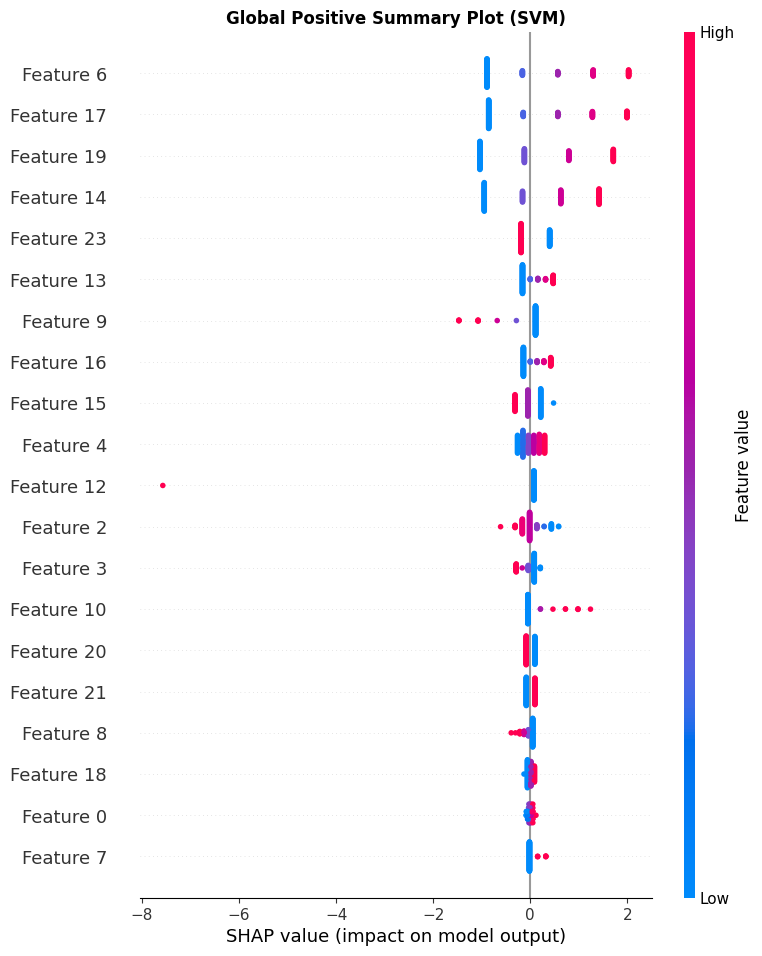

In [480]:
# SHAP Global Positive Summary Plot
shap.summary_plot(SVM_SHAP_VALUES, X_test, show=False)
plt.title("Global Positive Summary Plot (SVM)", fontdict={"fontweight":"bold"})
plt.show()

In [481]:
import pandas as pd

def print_top_shap_features(shap_values, feature_names, model_name="Model", top_n=10):
 
    shap_values_df = pd.DataFrame(shap_values, columns=feature_names)

    shap_values_sum = shap_values_df.abs().mean(axis=0)

    top_features = shap_values_sum.sort_values(ascending=False).head(top_n)

    print(f"\nTop {top_n} Features for {model_name} based on SHAP values:")
    print(top_features.to_frame(name='Mean Absolute SHAP Value'))

    return np.array(top_features.index)


In [482]:
top_features_svm = print_top_shap_features(SVM_SHAP_VALUES, feature_names=X.columns, model_name="SVC", top_n=10)
top_features_svm


Top 10 Features for SVC based on SHAP values:
                           Mean Absolute SHAP Value
Leukocytes                                 1.005181
WBC                                        0.974459
Amorphous Urate/Phosphate                  0.930743
Bacteria                                   0.862406
FEMALE                                     0.265950
Blood                                      0.223440
Glucose                                    0.199229
RBC                                        0.199141
Epithelial Cells                           0.180252
Spec Gravity                               0.166600


array(['Leukocytes', 'WBC', 'Amorphous Urate/Phosphate', 'Bacteria',
       'FEMALE', 'Blood', 'Glucose', 'RBC', 'Epithelial Cells',
       'Spec Gravity'], dtype=object)

In [483]:
top_features_lgbm = print_top_shap_features(LGBM_SHAP_VALUES, feature_names=X.columns, model_name="LGBMClassifier", top_n=10)
top_features_lgbm


Top 10 Features for LGBMClassifier based on SHAP values:
                           Mean Absolute SHAP Value
Amorphous Urate/Phosphate                  1.295041
Bacteria                                   1.131726
WBC                                        1.010847
Leukocytes                                 0.840819
Age                                        0.406025
Spec Gravity                               0.288905
Blood                                      0.251574
FEMALE                                     0.247914
Mucus Threads                              0.159758
Transparency                               0.146467


array(['Amorphous Urate/Phosphate', 'Bacteria', 'WBC', 'Leukocytes',
       'Age', 'Spec Gravity', 'Blood', 'FEMALE', 'Mucus Threads',
       'Transparency'], dtype=object)

In [484]:
top_features_xgb = print_top_shap_features(XGB_SHAP_VALUES, feature_names=X.columns, model_name="XGBClassifier", top_n=10)
top_features_xgb


Top 10 Features for XGBClassifier based on SHAP values:
                           Mean Absolute SHAP Value
Leukocytes                                 0.801875
Amorphous Urate/Phosphate                  0.778825
WBC                                        0.718141
Bacteria                                   0.690944
RBC                                        0.163713
Protein                                    0.084332
Mucus Threads                              0.072647
Age                                        0.068028
Color                                      0.065369
FEMALE                                     0.063813


array(['Leukocytes', 'Amorphous Urate/Phosphate', 'WBC', 'Bacteria',
       'RBC', 'Protein', 'Mucus Threads', 'Age', 'Color', 'FEMALE'],
      dtype=object)

In [485]:
top_features_logreg = print_top_shap_features(LOGREG_SHAP_VALUES, feature_names=X.columns, model_name="LogisitcRegression", top_n=10)


Top 10 Features for LogisitcRegression based on SHAP values:
                           Mean Absolute SHAP Value
Leukocytes                                 1.150137
Bacteria                                   1.090939
Amorphous Urate/Phosphate                  1.081969
WBC                                        0.955010
Blood                                      0.246964
Glucose                                    0.216444
Spec Gravity                               0.201438
RBC                                        0.196625
Bilirubin                                  0.158839
Mucus Threads                              0.151912


In [486]:
top_features_logreg = top_features_logreg.tolist()
top_features_logreg

['Leukocytes',
 'Bacteria',
 'Amorphous Urate/Phosphate',
 'WBC',
 'Blood',
 'Glucose',
 'Spec Gravity',
 'RBC',
 'Bilirubin',
 'Mucus Threads']

# REDUCED MODELS


In [487]:
all_features = X.columns.tolist()  

print(all_features)  


['Age', 'Clarity', 'Color', 'Transparency', 'Spec Gravity', 'pH Level', 'Leukocytes', 'Nitrite', 'Protein', 'Glucose', 'Ketones', 'Urobilinogen', 'Bilirubin', 'Blood', 'Bacteria', 'Epithelial Cells', 'RBC', 'WBC', 'Mucus Threads', 'Amorphous Urate/Phosphate', 'Marital Status_MARRIED', 'Marital Status_SINGLE', 'Marital Status_WIDOW', 'FEMALE', 'FILIPINO']


In [488]:
# Convert the top feature names to their corresponding indices in the original feature list
top_feature_indices_logreg = [all_features.index(feature) for feature in top_features_logreg]
top_feature_indices_lgbm = [all_features.index(feature) for feature in top_features_lgbm]
top_feature_indices_xgb = [all_features.index(feature) for feature in top_features_xgb]
top_feature_indices_svm = [all_features.index(feature) for feature in top_features_svm]

X_train_logreg = X_train[:, top_feature_indices_logreg]
X_test_logreg = X_test[:, top_feature_indices_logreg]

X_train_lgbm = X_train[:, top_feature_indices_lgbm]
X_test_lgbm = X_test[:, top_feature_indices_lgbm]

X_train_xgb = X_train[:, top_feature_indices_xgb]
X_test_xgb = X_test[:, top_feature_indices_xgb]

X_train_svm = X_train[:, top_feature_indices_svm]
X_test_svm = X_test[:, top_feature_indices_svm]

X_train_val_logreg = X_train_val[:, top_feature_indices_logreg]
X_test_val_logreg = X_test_val[:, top_feature_indices_logreg]

X_train_val_lgbm = X_train_val[:, top_feature_indices_lgbm]
X_test_val_lgbm = X_test_val[:, top_feature_indices_lgbm]

X_train_val_xgb = X_train_val[:, top_feature_indices_xgb]
X_test_val_xgb = X_test_val[:, top_feature_indices_xgb]

X_train_val_svm = X_train_val[:, top_feature_indices_svm]
X_test_val_svm = X_test_val[:, top_feature_indices_svm]


## Reduced Logistic Regression Optuna

In [489]:
def logreg_objective_r(trial: optuna.study.Study) -> float:
    PARAMS = {
        "tol": trial.suggest_float("tol", 1e-6, 1e-2, log=True),
        "C": trial.suggest_float("C", 0.1, 1)
    }

    LOGREG_R = LogisticRegression(**PARAMS, max_iter=2000, random_state=42)

    LOGREG_R.fit(X_train_val_logreg, y_train_val)

    THRESHOLD = trial.suggest_float('threshold', 0.1, 1)

    YHAT = [1 if proba[1] > THRESHOLD else 0 for proba in LOGREG_R.predict_proba(X_test_val_logreg)]

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

LOGREG_STUDY_R = optuna.create_study(direction="maximize", study_name="logreg_tuning_r", sampler=SAMPLER)

LOGREG_STUDY_R.optimize(logreg_objective_r, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-13 20:25:46,642] A new study created in memory with name: logreg_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-13 20:25:46,696] Trial 0 finished with value: 0.9655172413793104 and parameters: {'tol': 1.3733068336284023e-05, 'C': 0.43460016264423007, 'threshold': 0.4616652032320866}. Best is trial 0 with value: 0.9655172413793104.
[I 2024-11-13 20:25:46,723] Trial 5 finished with value: 0.9491525423728814 and parameters: {'tol': 0.0004547367375992681, 'C': 0.548925415718369, 'threshold': 0.3577380179975458}. Best is trial 0 with value: 0.9655172413793104.
[I 2024-11-13 20:25:46,731] Trial 1 finished with value: 0.9473684210526315 and parameters: {'tol': 2.131028201778351e-06, 'C': 0.8574495009138944, 'threshold': 0.6470733078598705}. Best is trial 0 with value: 0.9655172413793104.
[I 2024-11-13 20:25:46,735] Trial 2 finished with value: 0.9666666666666667 and parameters: {'tol': 4.1812253469472305e-05, 'C': 0.6948733295553435, 'threshold': 0.30809054131140456}. Best is trial 2 with value: 0.9666666666666667.
[I 2024-11-13 20:25:46,741] Trial 3 finished with value: 0.9666666666666667 a

In [490]:
show_study_summary(LOGREG_STUDY_R)

Best Hyperparameters
{'C': 0.6948733295553435,
 'threshold': 0.30809054131140456,
 'tol': 4.1812253469472305e-05}

Accuracy for the Best Hyperparameters
0.9666666666666667


## Reduced SVM Optuna

In [491]:
def SVC_objective_r(trial: optuna.study.Study) -> float:
    PARAMS = {
        "C": trial.suggest_float("C", 0.1, 1, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }

    SVC_MODEL_R = SVC(**PARAMS, probability=True, random_state=42)

    SVC_MODEL_R.fit(X_train_val_logreg, y_train_val)

    YHAT = SVC_MODEL_R.predict(X_test_val_logreg)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

SVM_SVC_STUDY_R = optuna.create_study(direction="maximize", study_name="SVM_tuning_r", sampler=SAMPLER)

SVM_SVC_STUDY_R.optimize(SVC_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-13 20:25:51,667] A new study created in memory with name: SVM_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-13 20:25:51,706] Trial 0 finished with value: 0.9310344827586207 and parameters: {'C': 0.42013743047503266, 'kernel': 'linear'}. Best is trial 0 with value: 0.9310344827586207.
[I 2024-11-13 20:25:51,722] Trial 1 finished with value: 0.9491525423728814 and parameters: {'C': 4.270666750280916, 'kernel': 'linear'}. Best is trial 1 with value: 0.9491525423728814.
[I 2024-11-13 20:25:51,726] Trial 5 finished with value: 0.9310344827586207 and parameters: {'C': 0.5501001306198813, 'kernel': 'linear'}. Best is trial 1 with value: 0.9491525423728814.
[I 2024-11-13 20:25:51,729] Trial 7 finished with value: 0.9655172413793104 and parameters: {'C': 2.3294861323772307, 'kernel': 'sigmoid'}. Best is trial 7 with value: 0.9655172413793104.
[I 2024-11-13 20:25:51,730] Trial 2 finished with value: 0.9491525423728814 and parameters: {'C': 7.153991181536264, 'kernel': 'linear'}. Best is trial 7 with value: 0.9655172413793104.
[I 2024-11-13 20:25:51,731] Trial 4 finished with value: 0.947368

In [492]:
show_study_summary(SVM_SVC_STUDY_R)

Best Hyperparameters
{'C': 2.3294861323772307, 'kernel': 'sigmoid'}

Accuracy for the Best Hyperparameters
0.9655172413793104


## Reduced XBG Optuna

In [493]:
def XGB_objective_r(trial: optuna.study.Study) -> float:

    PARAMS = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
        
    }

    XGB_MODEL_R = xgb.XGBClassifier(**PARAMS, random_state=42)

    XGB_MODEL_R.fit(X_train_val_xgb, y_train_val)

    YHAT = XGB_MODEL_R.predict(X_test_val_xgb)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

XGB_STUDY_R = optuna.create_study(direction="maximize", study_name="XGB_tuning_r", sampler=SAMPLER)

XGB_STUDY_R.optimize(XGB_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-13 20:25:54,714] A new study created in memory with name: XGB_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-13 20:25:55,064] Trial 6 finished with value: 0.9508196721311475 and parameters: {'reg_alpha': 0.5231905281288503, 'n_estimators': 200, 'max_depth': 14, 'learning_rate': 0.00043087909397949374, 'subsample': 0.92185738919025, 'colsample_bytree': 0.8065549286599769}. Best is trial 6 with value: 0.9508196721311475.
[I 2024-11-13 20:25:55,395] Trial 8 finished with value: 0.9655172413793104 and parameters: {'reg_alpha': 0.2971406588519464, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.04197433883057224, 'subsample': 0.538185767148283, 'colsample_bytree': 0.9869446855785367}. Best is trial 8 with value: 0.9655172413793104.
[I 2024-11-13 20:25:55,439] Trial 2 finished with value: 0.9375 and parameters: {'reg_alpha': 0.17474063900884274, 'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.0001034156778281099, 'subsample': 0.8524219354607865, 'colsample_bytree': 0.6681012839205343}. Best is trial 8 with value: 0.9655172413793104.
[I 2024-11-13 20:25:55,492] Trial 7 fi

In [494]:
show_study_summary(XGB_STUDY_R)

Best Hyperparameters
{'colsample_bytree': 0.541149408423103,
 'learning_rate': 0.0020102340419061063,
 'max_depth': 5,
 'n_estimators': 750,
 'reg_alpha': 0.29502449459101754,
 'subsample': 0.5408725513716501}

Accuracy for the Best Hyperparameters
0.9830508474576272


## Reduced LGBM Optuna

In [495]:
def lightgbm_objective_r(trial: optuna.study.Study) -> float:

    PARAMS = {
        "data_sample_strategy": "goss",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int('num_leaves', 10, 200, step=10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 3, 4, 5]),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }
    
    LGMB_MODEL_R = lgb.LGBMClassifier(**PARAMS, random_state=42)
    
    LGMB_MODEL_R.fit(X_train_val_lgbm, y_train_val) 
    
    YHAT = LGMB_MODEL_R.predict(X_test_val_lgbm)
    
    F1_SCORE_ = f1_score(y_test_val, YHAT)
    
    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

LGBM_STUDY_R = optuna.create_study(direction="maximize", study_name="lgbm_tuning_r", sampler=SAMPLER)

LGBM_STUDY_R.optimize(lightgbm_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-13 20:26:42,083] A new study created in memory with name: lgbm_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-13 20:26:42,181] Trial 0 finished with value: 0.6578947368421053 and parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.018529291291044487, 'reg_alpha': 0.48686355456235697, 'subsample': 0.6494098702929495, 'colsample_bytree': 0.8852580233810452, 'min_child_samples': 75}. Best is trial 0 with value: 0.6578947368421053.
[I 2024-11-13 20:26:42,204] Trial 1 finished with value: 0.9090909090909091 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.0005995337788156396, 'reg_alpha': 0.5689979583169656, 'subsample': 0.9179119685399273, 'colsample_bytree': 0.8744459880789762, 'min_child_samples': 92}. Best is trial 1 with value: 0.9090909090909091.
[I 2024-11-13 20:26:42,245] Trial 8 finished with value: 0.8955223880597015 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0017785017867929522, 

In [496]:
show_study_summary(LGBM_STUDY_R)

Best Hyperparameters
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6327831888814561,
 'learning_rate': 0.04396147538861922,
 'max_depth': 4,
 'min_child_samples': 24,
 'n_estimators': 250,
 'num_leaves': 120,
 'reg_alpha': 0.646236320768619,
 'subsample': 0.8632800905489895}

Accuracy for the Best Hyperparameters
0.9830508474576272


In [498]:
LIST_OF_MODELS_R = [LogisticRegression, SVC, xgb.XGBClassifier, lgb.LGBMClassifier]

MODELS_PARAMETERS_R = {
    "LogisticRegression_R":{'C': 0.843188809668418,
                            'threshold': 0.2480759459607349,
                            'tol': 0.00010313489032402146
                            },
    "SVC_R":{'C':  1.5012348935720334, 'kernel': 'linear'},
    "XGBClassifier_R":{'colsample_bytree': 0.6987143347296634,
                        'learning_rate': 0.009748439472218588,
                        'max_depth': 12,
                        'n_estimators': 350,
                        'reg_alpha': 0.726399417441595,
                        'subsample': 0.5234177371400572
                        },
   
    "LGBMClassifier_R": {"data_sample_strategy": "goss", "verbosity": -1, 
                        'boosting_type': 'gbdt',
                        'colsample_bytree': 0.6473584225455065,
                        'learning_rate': 0.0033266936612184545,
                        'max_depth': -1,
                        'min_child_samples': 64,
                        'n_estimators': 250,
                        'num_leaves': 50,
                        'reg_alpha': 0.8152197352921863,
                        'subsample': 0.9848477160046183
                        }
}

X_train_list = [
    X_train_logreg,  # LogisticRegression
    X_train_svm,     # SVC
    X_train_xgb,     # XGBClassifier
    X_train_lgbm     # LGBMClassifier
]

X_test_list = [
    X_test_logreg,  # LogisticRegression
    X_test_svm,     # SVC
    X_test_xgb,     # XGBClassifier
    X_test_lgbm     # LGBMClassifier
]

MODEL_CONTAINER_R = {}

TESTING_SCORES_R = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "Specificity", "AUC-ROC"])

for i, model_class in enumerate(LIST_OF_MODELS_R):

    X_train_current = X_train_list[i]
    X_test_current = X_test_list[i]

    model_name = list(MODELS_PARAMETERS_R.keys())[i]
    model_params = MODELS_PARAMETERS_R[model_name]
    
    model_container, test_scores = test_model([model_class], 
                                              {model_name: model_params}, 
                                              X_train_current, 
                                              y_train, 
                                              X_test_current, 
                                              y_test)
    
    MODEL_CONTAINER_R[model_name] = model_container[model_name]

    TESTING_SCORES_R = pd.concat([TESTING_SCORES_R, test_scores], ignore_index=True)


100%|██████████| 1/1 [00:00<00:00, 37.89it/s]


In [499]:
TESTING_SCORES_R

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  LogisticRegression_R  0.951613   0.925373  0.984127  0.953846     0.918033   
1                 SVC_R  0.943548   0.951613  0.936508  0.944000     0.950820   
2       XGBClassifier_R  0.959677   0.953125  0.968254  0.960630     0.950820   
3      LGBMClassifier_R  0.927419   0.965517  0.888889  0.925620     0.967213   

    AUC-ROC  
0  0.951080  
1  0.943664  
2  0.959537  
3  0.928051

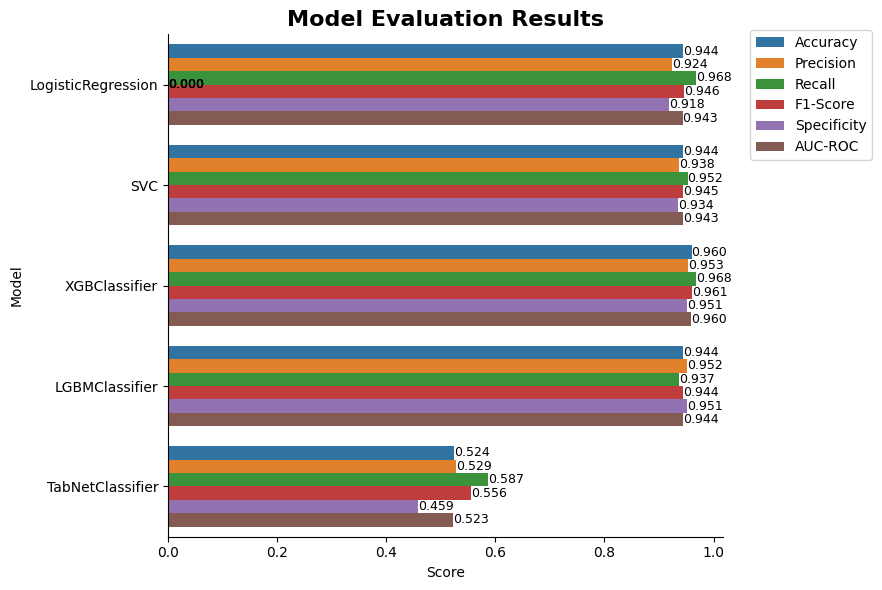

In [500]:
# Prepare data for plotting
plot_df = pd.melt(TESTING_SCORES, id_vars=["Model"])
plot_df.rename({"variable": "Metric", "value": "Score"}, axis=1, inplace=True)

PLOT = sns.catplot(
    x="Score", 
    y="Model", 
    hue="Metric", 
    data=plot_df, 
    kind="bar", 
    orient="h",
    height=6, 
    aspect=1.5, 
    legend_out=False,
    palette="tab10"  
)

# Access the axes of the plot
ax = PLOT.axes[0, 0]

# Annotate the bars with their corresponding scores
for p in ax.patches:
    ax.annotate(f"{p.get_width():.3f}", 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha="left", va="center", fontsize=9)

# Set plot title and legend
plt.title("Model Evaluation Results", fontsize=16, fontweight='bold')
plt.legend(loc=(1.05, 0.75))
plt.tight_layout()

# Display the plot
plt.show()


In [501]:
MODELS_TESTING_SCORES = pd.concat([TESTING_SCORES, TESTING_SCORES_R], axis=0)
MODELS_TESTING_SCORES

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0    LogisticRegression  0.943548   0.924242  0.968254  0.945736     0.918033   
1                   SVC  0.943548   0.937500  0.952381  0.944882     0.934426   
2         XGBClassifier  0.959677   0.953125  0.968254  0.960630     0.950820   
3        LGBMClassifier  0.943548   0.951613  0.936508  0.944000     0.950820   
4      TabNetClassifier  0.524194   0.528571  0.587302  0.556391     0.459016   
0  LogisticRegression_R  0.951613   0.925373  0.984127  0.953846     0.918033   
1                 SVC_R  0.943548   0.951613  0.936508  0.944000     0.950820   
2       XGBClassifier_R  0.959677   0.953125  0.968254  0.960630     0.950820   
3      LGBMClassifier_R  0.927419   0.965517  0.888889  0.925620     0.967213   

    AUC-ROC  
0  0.943143  
1  0.943404  
2  0.959537  
3  0.943664  
4  0.523159  
0  0.951080  
1  0.943664  
2  0.959537  
3  0.928051

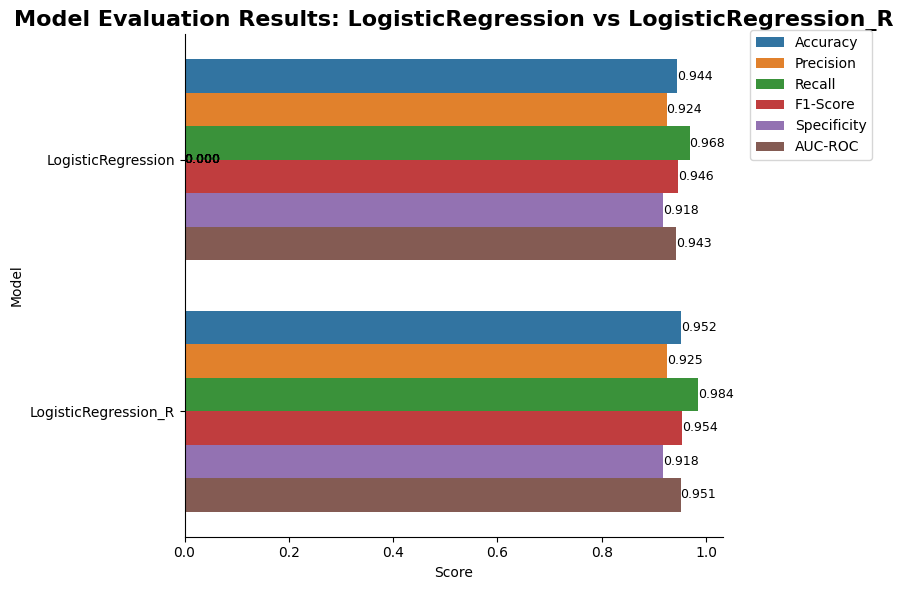

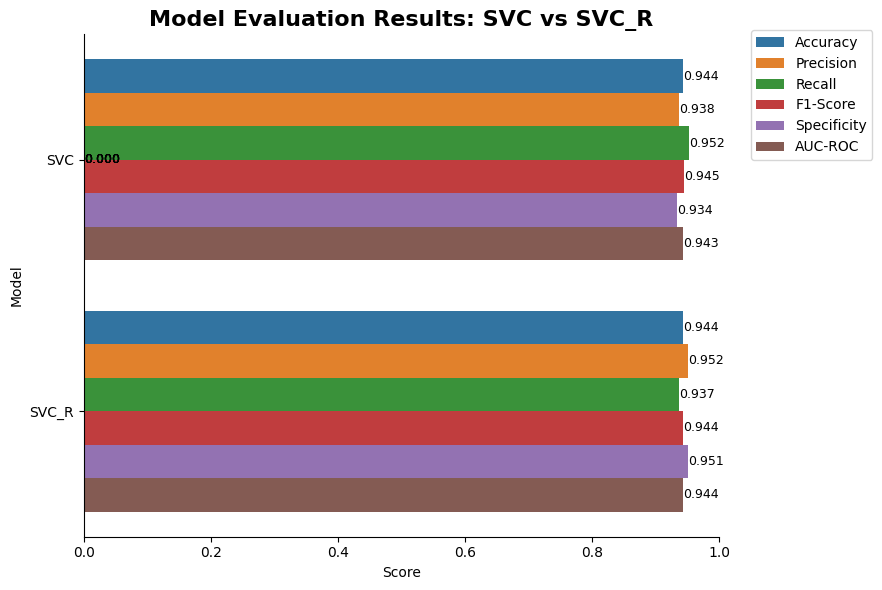

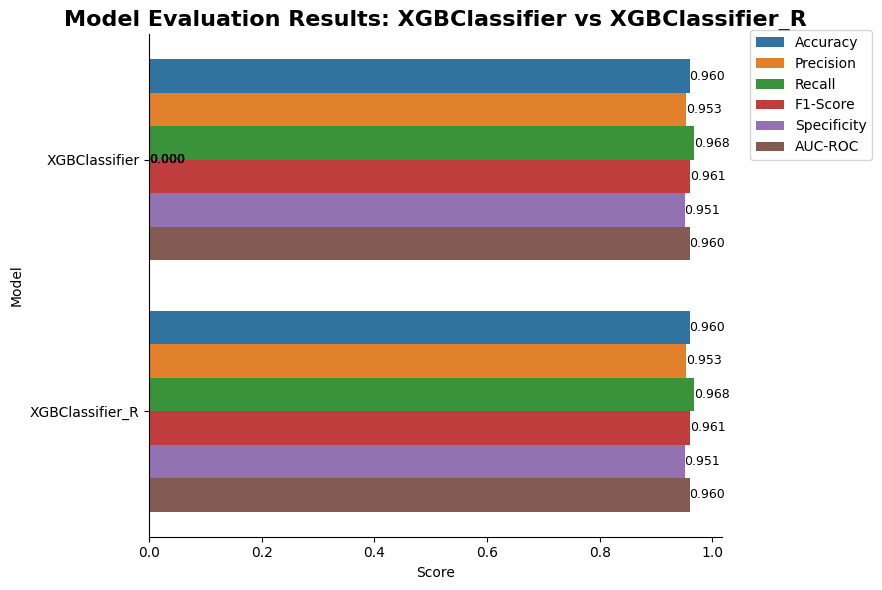

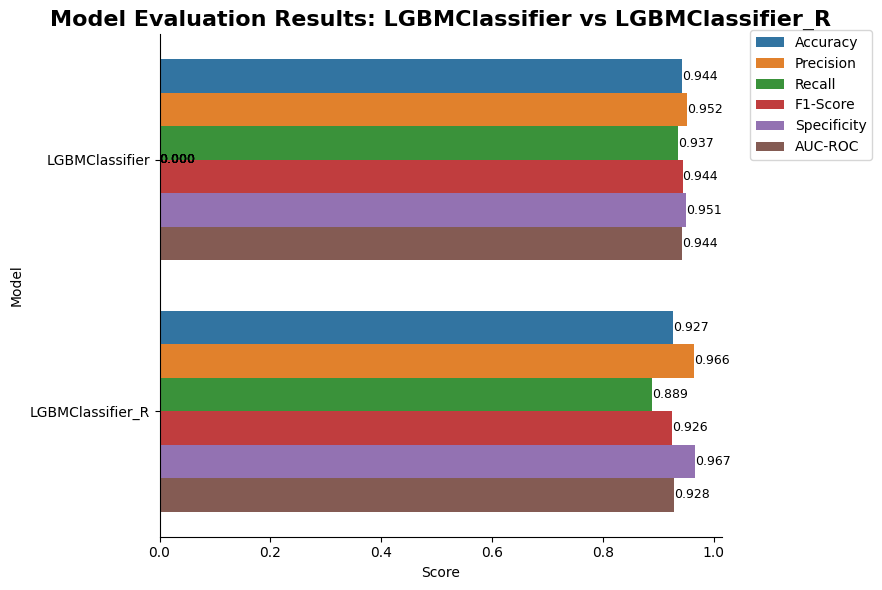

In [502]:
normal_models = TESTING_SCORES['Model'].unique()
reduced_models = TESTING_SCORES_R['Model'].unique()

# Loop through each model and its reduced counterpart
for normal_model, reduced_model in zip(normal_models, reduced_models):
    
    # Filter out the scores for the current model and its reduced counterpart
    normal_model_scores = TESTING_SCORES[TESTING_SCORES['Model'] == normal_model]
    reduced_model_scores = TESTING_SCORES_R[TESTING_SCORES_R['Model'] == reduced_model]
    
    # Combine the scores into one dataframe for plotting
    combined_scores = pd.concat([normal_model_scores, reduced_model_scores])

    # Prepare data for plotting
    plot_df = pd.melt(combined_scores, id_vars=["Model"])
    plot_df.rename({"variable": "Metric", "value": "Score"}, axis=1, inplace=True)
    
    PLOT = sns.catplot(
        x="Score", 
        y="Model", 
        hue="Metric", 
        data=plot_df, 
        kind="bar", 
        orient="h",
        height=6, 
        aspect=1.5, 
        legend_out=False,
        palette="tab10"  
    )
    
    # Access the axes of the plot
    ax = PLOT.axes[0, 0]
    
    # Annotate the bars with their corresponding scores
    for p in ax.patches:
        ax.annotate(f"{p.get_width():.3f}", 
                    (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                    ha="left", va="center", fontsize=9)
    
    # Set plot title for each model and its reduced version
    plt.title(f"Model Evaluation Results: {normal_model} vs {reduced_model}", fontsize=16, fontweight='bold')
    
    # Set legend and show the plot
    plt.legend(loc=(1.05, 0.75))
    plt.tight_layout()
    plt.show()


In [503]:
XGB_PREDICTED_PROBA = TRAINED_XGB.predict_proba(X_test)
LGBM_PREDICTED_PROBA = TRAINED_LGBM.predict_proba(X_test)
SVM_PREDICTED_PROBA = TRAINED_SVM.predict_proba(X_test)

In [504]:
weight_xgb = 0.33
weight_lgbm = 0.33
weight_svc = 0.33

TOP3_WAVERAGE_PREDICTIONS = (weight_lgbm * LGBM_PREDICTED_PROBA + weight_xgb * XGB_PREDICTED_PROBA + weight_svc * SVM_PREDICTED_PROBA) / (weight_lgbm + weight_xgb + weight_svc)

In [505]:
TOP3_LABELED_PREDICTIONS = np.argmax(TOP3_WAVERAGE_PREDICTIONS, axis=1)

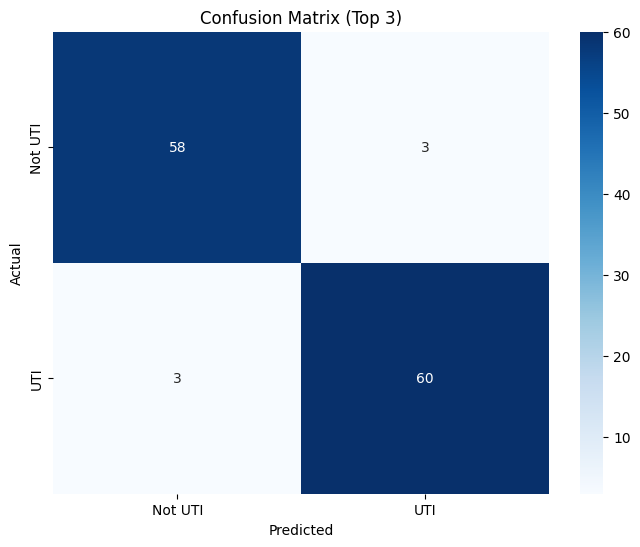

In [506]:
T2_CM = confusion_matrix(y_test, TOP3_LABELED_PREDICTIONS)

plt.figure(figsize=(8, 6))
sns.heatmap(T2_CM, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=["Not UTI", "UTI"], yticklabels=["Not UTI", "UTI"])
plt.title("Confusion Matrix (Top 3)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [507]:
# Compute evaluation metrics using scikit-learn functions
T3_ACCURACY = accuracy_score(y_test, TOP3_LABELED_PREDICTIONS)
T3_F1 = f1_score(y_test, TOP3_LABELED_PREDICTIONS)
T3_RECALL = recall_score(y_test, TOP3_LABELED_PREDICTIONS)
T3_PRECISION = precision_score(y_test, TOP3_LABELED_PREDICTIONS)

# Compute additional metrics (confusion matrix, specificity, ROC AUC)
T3_TN, T3_FP, _, _ = confusion_matrix(y_test, TOP3_LABELED_PREDICTIONS).ravel()
T3_SPECIFICITY = T3_TN / (T3_TN + T3_FP)
T3_ROC_AUC = roc_auc_score(y_test, TOP3_LABELED_PREDICTIONS)

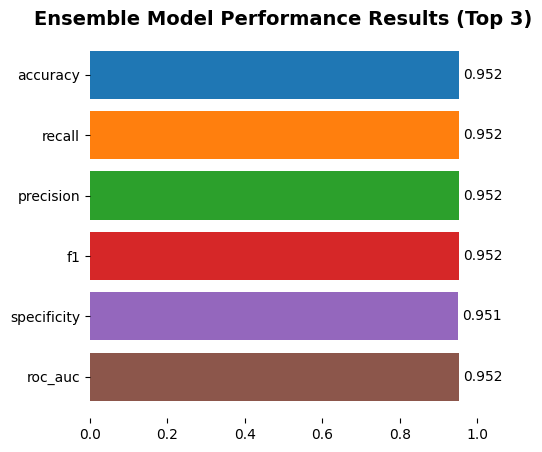

In [508]:
# Create a horizontal bar plot with specified figure size
fig, axs = plt.subplots(figsize=(5, 5))

bar_graph = axs.barh(
    ["accuracy", "recall", "precision", "f1", "specificity", "roc_auc"],
    [T3_ACCURACY, T3_RECALL, T3_PRECISION, T3_F1, T3_SPECIFICITY, T3_ROC_AUC],
    color=sns.color_palette("tab10")  
)

# Add labels to the bars with the corresponding values
axs.bar_label(bar_graph, labels=[f"{x:.3f}" for x in bar_graph.datavalues], padding=3)

# Remove spines for aesthetics
for spine in ["top", "bottom", "left", "right"]:
    axs.spines[spine].set_visible(False)

# Invert y-axis for better visualization
axs.invert_yaxis()

# Set plot title and display the plot
plt.title("Ensemble Model Performance Results (Top 3)", fontsize=14, fontweight='bold')
plt.show()


In [509]:
# Save each model
import joblib
joblib.dump(TRAINED_XGB, "trained_xgb_model.pkl")
joblib.dump(TRAINED_SVM, "trained_svm_model.pkl")
joblib.dump(TRAINED_LGBM, "trained_lgbm_model.pkl")


['trained_lgbm_model.pkl']

In [510]:
ensemble_weights = {'weight_xgb': 0.33, 'weight_lgbm': 0.33, 'weight_svc': 0.33}
joblib.dump(ensemble_weights, "ensemble_weights.pkl")

['ensemble_weights.pkl']

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Original data split (unscaled) to match scaled split
X_train_orig, X_test_orig, _, _ = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Make predictions on the scaled test data
y_pred = TRAINED_XGB.predict(X_test)

# Convert y_test and y_pred to numpy arrays for compatibility
y_test_array = np.array(y_test)
y_pred_array = np.array(y_pred)

# Identify misclassified rows
misclassified_indices = (y_pred_array != y_test_array)  

misclassified_original_rows = X_test_orig[misclassified_indices].copy()  

misclassified_original_rows["Actual"] = y_test_array[misclassified_indices]
misclassified_original_rows["Predicted"] = y_pred_array[misclassified_indices]

print("Index\t" + "\t".join(misclassified_original_rows.columns))  
for index, row in misclassified_original_rows.iterrows():
    row_values = [str(index)] + [str(row[col]) for col in misclassified_original_rows.columns]  
    print("\t".join(row_values))  


Index	Age	Clarity	Color	Transparency	Spec Gravity	pH Level	Leukocytes	Nitrite	Protein	Glucose	Ketones	Urobilinogen	Bilirubin	Blood	Bacteria	Epithelial Cells	RBC	WBC	Mucus Threads	Amorphous Urate/Phosphate	Marital Status_MARRIED	Marital Status_SINGLE	Marital Status_WIDOW	FEMALE	FILIPINO	Actual	Predicted
107	11.0	0	4	1	1.015	6.5	0	0	1	0	0	1	0	2	1	2	2	0	1	2	False	True	False	False	True	0	1
86	57.0	0	5	1	1.02	6.0	0	0	1	0	0	1	0	1	1	1	1	0	1	2	False	True	False	True	True	1	0
38	15.0	0	5	4	1.025	6.5	0	2	1	1	0	1	0	0	3	3	0	0	3	3	False	True	False	True	True	0	1
390	19.0	0	5	1	1.025	5.0	0	0	0	0	4	1	0	0	2	2	0	0	2	2	False	True	False	True	True	0	1
193	10.0	0	4	1	1.01	7.0	0	0	2	0	0	1	0	0	0	1	0	0	1	1	False	True	False	False	True	1	0


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Original data split (unscaled) to match scaled split
X_train_orig, X_test_orig, _, _ = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Make predictions on the scaled test data
y_pred = TRAINED_LGBM.predict(X_test)

# Convert y_test and y_pred to numpy arrays for compatibility
y_test_array = np.array(y_test)
y_pred_array = np.array(y_pred)

# Identify misclassified rows
misclassified_indices = (y_pred_array != y_test_array)  

misclassified_original_rows = X_test_orig[misclassified_indices].copy()  

misclassified_original_rows["Actual"] = y_test_array[misclassified_indices]
misclassified_original_rows["Predicted"] = y_pred_array[misclassified_indices]

print("Index\t" + "\t".join(misclassified_original_rows.columns))  
for index, row in misclassified_original_rows.iterrows():
    row_values = [str(index)] + [str(row[col]) for col in misclassified_original_rows.columns]  
    print("\t".join(row_values))  


Index	Age	Clarity	Color	Transparency	Spec Gravity	pH Level	Leukocytes	Nitrite	Protein	Glucose	Ketones	Urobilinogen	Bilirubin	Blood	Bacteria	Epithelial Cells	RBC	WBC	Mucus Threads	Amorphous Urate/Phosphate	Marital Status_MARRIED	Marital Status_SINGLE	Marital Status_WIDOW	FEMALE	FILIPINO	Actual	Predicted
107	11.0	0	4	1	1.015	6.5	0	0	1	0	0	1	0	2	1	2	2	0	1	2	False	True	False	False	True	0	1
86	57.0	0	5	1	1.02	6.0	0	0	1	0	0	1	0	1	1	1	1	0	1	2	False	True	False	True	True	1	0
19	60.0	0	4	1	1.02	5.0	1	1	0	0	0	1	0	0	2	2	0	0	1	1	True	False	False	True	True	1	0
38	15.0	0	5	4	1.025	6.5	0	2	1	1	0	1	0	0	3	3	0	0	3	3	False	True	False	True	True	0	1
66	30.0	0	4	1	1.01	6.5	1	0	0	0	0	1	0	0	1	2	0	1	1	0	True	False	False	True	True	1	0
390	19.0	0	5	1	1.025	5.0	0	0	0	0	4	1	0	0	2	2	0	0	2	2	False	True	False	True	True	0	1
193	10.0	0	4	1	1.01	7.0	0	0	2	0	0	1	0	0	0	1	0	0	1	1	False	True	False	False	True	1	0
